In [24]:
# data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imb_pipeline

# model building
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# accuracy
from sklearn.metrics import classification_report, plot_confusion_matrix, roc_auc_score

# other
import pickle
import warnings;warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('healthcare_preprocessed.csv')
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,80.0,0,1,0,0,4.662684,3.481240,1,0,0,1,0,0,0,0,1,0
1,1,74.0,1,1,0,0,4.249780,3.310543,1,0,0,1,0,0,0,0,1,0
2,0,69.0,0,0,0,0,4.547435,3.126761,1,0,0,1,0,0,0,0,1,0
3,0,59.0,0,0,0,0,4.332705,3.335770,1,0,0,1,0,0,1,0,0,0
4,0,78.0,0,0,0,0,4.070223,3.186353,1,0,0,1,0,0,1,0,0,0


#### Model with all columns

In [3]:
# feature and label
features = df.drop('stroke', axis=1)
label = df['stroke']
print(features.shape, label.shape)

(4390, 17) (4390,)


In [4]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=21)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3512, 17) (878, 17) (3512,) (878,)


In [5]:
# to balance the target class we will be using smote on training data
over = SMOTE(sampling_strategy=0.2, k_neighbors=2)
under = RandomUnderSampler(sampling_strategy=0.3)

balancer = imb_pipeline([
    ('Over', over),
    ('Under', under)
])

In [6]:
x_train_, y_train_ = balancer.fit_resample(x_train, y_train)
print(x_train_.shape, y_train_.shape)

(2933, 17) (2933,)


In [7]:
# logistic regression pipeline
lr_model = Pipeline([
    ('Scaler', StandardScaler()),
    ('LR_Classifier', LogisticRegression())
])

# decision tree model pipeline
dt_model = Pipeline([
    ('Scaler', StandardScaler()),
    ('LR_Classifier', DecisionTreeClassifier(random_state=91))
])

# xgb model pipeline
xgb_model = Pipeline([
    ('Scaler', StandardScaler()),
    ('LR_Classifier', XGBClassifier(random_state=0))
])

Since we are trying to predict if a person is likely to have stroke or not, it is important for us to not miss the patient who could have this as it would be risker for him. So we will be looking for low false negative in stroke prediction. Also we will be looking for high stroke prediction precision.

Logistic Regression
(lr_model) Training set score: 0.8929423798158882
(lr_model) Test set score: 0.9043280182232346 

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       837
           1       0.16      0.24      0.19        41

    accuracy                           0.90       878
   macro avg       0.56      0.59      0.57       878
weighted avg       0.92      0.90      0.91       878



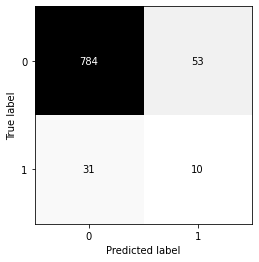

In [8]:
print("Logistic Regression")

lr_model.fit(x_train_, y_train_)
print('(lr_model) Training set score: ' + str(lr_model.score(x_train_, y_train_)))
print('(lr_model) Test set score: ' + str(lr_model.score(x_test, y_test)), '\n')

print(classification_report(y_test, lr_model.predict(x_test)))
plot_confusion_matrix(lr_model, x_test, y_test, colorbar=False, cmap='binary')

> * It's test score is impressive and doesn't seems to be overfitted
> * but its score isn't that good on predicting stroke class

Decision Tree
(dt_model) Training set score: 1.0
(dt_model) Test set score: 0.8815489749430524 

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       837
           1       0.12      0.24      0.16        41

    accuracy                           0.88       878
   macro avg       0.54      0.58      0.55       878
weighted avg       0.92      0.88      0.90       878



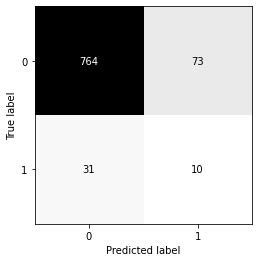

In [9]:
print("Decision Tree")

dt_model.fit(x_train_, y_train_)
print('(dt_model) Training set score: ' + str(dt_model.score(x_train_, y_train_)))
print('(dt_model) Test set score: ' + str(dt_model.score(x_test, y_test)), '\n')

print(classification_report(y_test, dt_model.predict(x_test)))
plot_confusion_matrix(dt_model, x_test, y_test, colorbar=False, cmap='binary')

> * Model is overfitted
> * stroke class precision is very less

XGBoost
[08:58:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(xgb_model) Training set score: 1.0
(xgb_model) Test set score: 0.9305239179954442
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       837
           1       0.19      0.15      0.16        41

    accuracy                           0.93       878
   macro avg       0.57      0.56      0.56       878
weighted avg       0.92      0.93      0.93       878



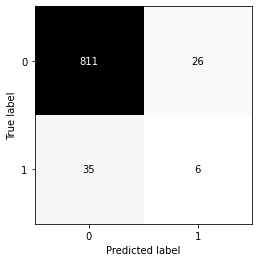

In [10]:
print("XGBoost")

xgb_model.fit(x_train_, y_train_)
print('(xgb_model) Training set score: ' + str(xgb_model.score(x_train_, y_train_)))
print('(xgb_model) Test set score: ' + str(xgb_model.score(x_test, y_test)))

print(classification_report(y_test, xgb_model.predict(x_test)))
plot_confusion_matrix(xgb_model, x_test, y_test, colorbar=False, cmap='binary')


> * It is also overfitted
> * not an impressive performance on stroke class

#### Model with best column (Information gain)

In [14]:
# these columns selected from last eda's notebook information gain
columns = ['gender', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 'work_type_Govt_job',
             'work_type_Private', 'smoking_status_formerly smoked', 'smoking_status_smokes']
features_ig = features.drop(columns, axis=1)

# train test split
x_train_ig, x_test_ig, y_train_ig, y_test_ig = train_test_split(features_ig, label, test_size=0.2, random_state=21)
print(x_train_ig.shape, x_test_ig.shape, y_train_ig.shape, y_test_ig.shape)

(3512, 8) (878, 8) (3512,) (878,)


In [15]:
x_train_ig, y_train_ig = balancer.fit_resample(x_train_ig, y_train_ig)
print(x_train_ig.shape, y_train_ig.shape)

(2933, 8) (2933,)


Logistic Regression with Features selection
(lr_model) Training set score: 0.8029321513808387
(lr_model) Test set score: 0.8804100227790432 

              precision    recall  f1-score   support

           0       0.97      0.90      0.94       837
           1       0.17      0.39      0.23        41

    accuracy                           0.88       878
   macro avg       0.57      0.65      0.58       878
weighted avg       0.93      0.88      0.90       878



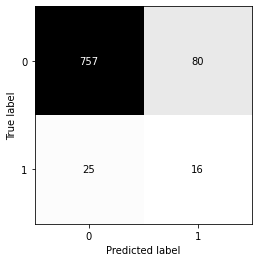

In [16]:
print("Logistic Regression with Features selection")

lr_model.fit(x_train_ig, y_train_ig)
print('(lr_model) Training set score: ' + str(lr_model.score(x_train_ig, y_train_ig)))
print('(lr_model) Test set score: ' + str(lr_model.score(x_test_ig, y_test_ig)), '\n')

print(classification_report(y_test_ig, lr_model.predict(x_test_ig)))
plot_confusion_matrix(lr_model, x_test_ig, y_test_ig, colorbar=False, cmap='binary')

> * Feature selection did improved the stroke prediction performance

Decision Tree with Features selection
(dt_model) Training set score: 0.9982952608250938
(dt_model) Test set score: 0.8917995444191344 

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       837
           1       0.19      0.39      0.25        41

    accuracy                           0.89       878
   macro avg       0.58      0.65      0.60       878
weighted avg       0.93      0.89      0.91       878



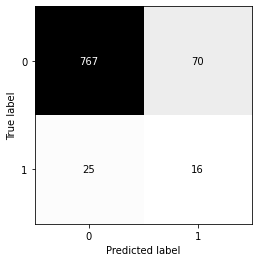

In [17]:
print("Decision Tree with Features selection")

dt_model.fit(x_train_ig, y_train_ig)
print('(dt_model) Training set score: ' + str(dt_model.score(x_train_ig, y_train_ig)))
print('(dt_model) Test set score: ' + str(dt_model.score(x_test_ig, y_test_ig)), '\n')

print(classification_report(y_test_ig, dt_model.predict(x_test_ig)))
plot_confusion_matrix(dt_model, x_test_ig, y_test_ig, colorbar=False, cmap='binary')

> * There is little improvement in stroke prediction but it is still overfitted

xgboost with Features selection
[09:29:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(xgb_model) Training set score: 0.9778383907262189
(xgb_model) Test set score: 0.908883826879271 

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       837
           1       0.20      0.32      0.25        41

    accuracy                           0.91       878
   macro avg       0.58      0.63      0.60       878
weighted avg       0.93      0.91      0.92       878



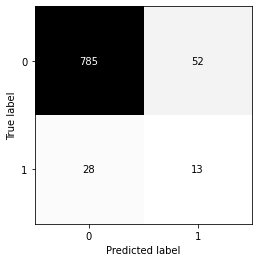

In [18]:
print("xgboost with Features selection")

xgb_model.fit(x_train_ig, y_train_ig)
print('(xgb_model) Training set score: ' + str(xgb_model.score(x_train_ig, y_train_ig)))
print('(xgb_model) Test set score: ' + str(xgb_model.score(x_test_ig, y_test_ig)), '\n')

print(classification_report(y_test_ig, xgb_model.predict(x_test_ig)))
plot_confusion_matrix(xgb_model, x_test_ig, y_test_ig, colorbar=False, cmap='binary')

> * xgboost is also overfitted

#### Model with best column (Variance Threshold)

In [19]:
# these columns selected from last eda's notebook information gain
columns = ['hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'work_type_Never_worked']
features_vt = features.drop(columns, axis=1)

# train test split
x_train_vt, x_test_vt, y_train_vt, y_test_vt = train_test_split(features_vt, label, test_size=0.2, random_state=21)
print(x_train_vt.shape, x_test_vt.shape, y_train_vt.shape, y_test_vt.shape)

(3512, 12) (878, 12) (3512,) (878,)


In [20]:
x_train_vt, y_train_vt = balancer.fit_resample(x_train_vt, y_train_vt)
print(x_train_vt.shape, y_train_vt.shape)

(2933, 12) (2933,)


Logistic Regression with Features selection
(lr_model) Training set score: 0.8810092055915445
(lr_model) Test set score: 0.8986332574031891 

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       837
           1       0.18      0.34      0.24        41

    accuracy                           0.90       878
   macro avg       0.58      0.63      0.59       878
weighted avg       0.93      0.90      0.91       878



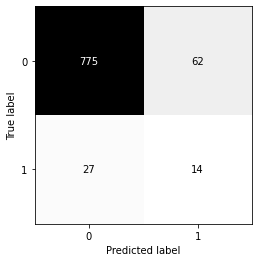

In [21]:
print("Logistic Regression with Features selection")

lr_model.fit(x_train_vt, y_train_vt)
print('(lr_model) Training set score: ' + str(lr_model.score(x_train_vt, y_train_vt)))
print('(lr_model) Test set score: ' + str(lr_model.score(x_test_vt, y_test_vt)), '\n')

print(classification_report(y_test_vt, lr_model.predict(x_test_vt)))
plot_confusion_matrix(lr_model, x_test_vt, y_test_vt, colorbar=False, cmap='binary')

> * Model has improvement from first model but isn't better than our last model

Decision Tree with Features selection
(dt_model) Training set score: 0.9624957381520627
(dt_model) Test set score: 0.9236902050113895 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       837
           1       0.12      0.10      0.11        41

    accuracy                           0.92       878
   macro avg       0.54      0.53      0.53       878
weighted avg       0.92      0.92      0.92       878



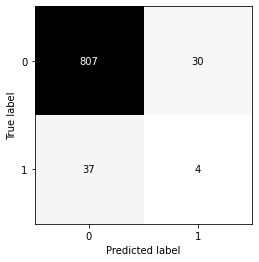

In [22]:
print("Decision Tree with Features selection")

dt_model.fit(x_train_vt, y_train_vt)
print('(dt_model) Training set score: ' + str(dt_model.score(x_train_vt, y_train_vt)))
print('(dt_model) Test set score: ' + str(dt_model.score(x_test_vt, y_test_vt)), '\n')

print(classification_report(y_test_vt, dt_model.predict(x_test_vt)))
plot_confusion_matrix(dt_model, x_test_vt, y_test_vt, colorbar=False, cmap='binary')

> * these new features doesn't helped decision tree in better stroke predicition

xgboost with Features selection
[09:32:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(xgb_model) Training set score: 0.958745311967269
(xgb_model) Test set score: 0.929384965831435 

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       837
           1       0.16      0.12      0.14        41

    accuracy                           0.93       878
   macro avg       0.56      0.55      0.55       878
weighted avg       0.92      0.93      0.92       878



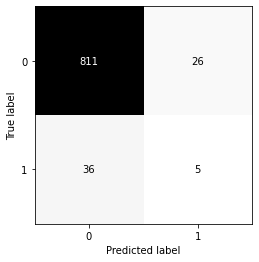

In [23]:
print("xgboost with Features selection")

xgb_model.fit(x_train_vt, y_train_vt)
print('(xgb_model) Training set score: ' + str(xgb_model.score(x_train_vt, y_train_vt)))
print('(xgb_model) Test set score: ' + str(xgb_model.score(x_test_vt, y_test_vt)), '\n')

print(classification_report(y_test_vt, xgb_model.predict(x_test_vt)))
plot_confusion_matrix(xgb_model, x_test_vt, y_test_vt, colorbar=False, cmap='binary')

#### Saving model

> * It is also not improved from new selected features

In [25]:
lr_model.fit(x_train_ig, y_train_ig)

# dumping our model 
import pickle
with open('model.pik', 'wb') as files:
    pickle.dump(lr_model, files)